In [1]:
%reload_ext autoreload
%autoreload 2

import requests
import matplotlib.pyplot as plt
import json
import csv
import os
import pandas as pd
import numpy as np

from fmp_python.fmp import FMP
from fmp_api_python.fmp import FMPClient

from xgbimputer import XGBImputer

import math
from scipy.stats import norm

import nest_asyncio
from aiohttp import ClientSession
import aiofiles
import aiohttp
import asyncio

from tqdm import tqdm

from scipy import signal
from skimage.restoration import (denoise_wavelet, estimate_sigma)

import miceforest as mf #miceforest imputation
import tensorflow as tf
import MIDASpy as md


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import missingno as msno # missingness plot



/Users/veesheenyuen/.pyenv/versions/3.10.6/envs/credit-spreads/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# VIX Data

In [2]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

vix=pd.read_csv('raw_data/VIX_History.csv')

vix

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26
...,...,...,...,...,...
8332,01/25/2023,19.56,20.90,18.99,19.08
8333,01/26/2023,19.05,19.48,18.67,18.73
8334,01/27/2023,18.90,19.00,17.97,18.51
8335,01/30/2023,19.76,20.25,19.54,19.94


# JGB Yield Curves

In [5]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

japan_curves=pd.read_csv('raw_data/Yield Curves/jgbcme_all.csv')


In [6]:
japan_curves

,Interest Rate,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,(Unit : %)
0,Date,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
1,1974/9/24,10.327,9.362,8.83,8.515,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
2,1974/9/25,10.333,9.364,8.831,8.516,8.348,8.29,8.24,8.121,8.127,-,-,-,-,-,-
3,1974/9/26,10.34,9.366,8.832,8.516,8.348,8.29,8.24,8.122,8.128,-,-,-,-,-,-
4,1974/9/27,10.347,9.367,8.833,8.517,8.349,8.29,8.24,8.122,8.128,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12410,2023/1/25,-0.045,-0.01,0.004,0.083,0.189,0.257,0.317,0.424,0.415,0.457,1.001,1.299,1.464,1.535,1.69
12411,2023/1/26,-0.055,-0.009,0.006,0.083,0.189,0.252,0.311,0.429,0.432,0.483,1.021,1.313,1.47,1.526,1.671
12412,2023/1/27,-0.055,0.001,0.014,0.095,0.2,0.283,0.364,0.485,0.51,0.497,1.087,1.377,1.518,1.574,1.697
12413,2023/1/30,-0.055,-0.004,0.011,0.087,0.187,0.273,0.361,0.472,0.493,0.497,1.09,1.386,1.534,1.596,1.725


# Euro Zone Yield Curves

In [7]:
## Read large kaggle quarterly FS file

os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")
data = pd.read_csv('quarterly.csv')

data

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_49758/554400424.py:4: DtypeWarning: Columns (10,12,13,17,18,20,25,26,30,32,33,34,35,647,648,649,650,654,656,657,664,668,669,674,675,677,678,679) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('quarterly.csv')


,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1000,03/31/1966,1966,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
1,1000,06/30/1966,1966,2,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
2,1000,09/30/1966,1966,3,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
3,1000,12/31/1966,1966,4,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
4,1000,03/31/1967,1967,1,12,INDL,C,D,STD,AE.2,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,06/30/1978,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829911,339965,10/31/2019,2019,3,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829912,339965,01/31/2020,2019,4,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829913,339965,04/30/2020,2020,1,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020
1829914,339965,07/31/2020,2020,2,1,INDL,C,D,STD,SNOW,...,1.0,NaN,NaN,NaN,NaN,CA,0.0,www.snowflake.com,NaN,09/10/2020


In [159]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

euro_curves=pd.read_csv('raw_data/Yield Curves/euro_yield_curves.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/Yield Curves/euro_yield_curves.csv'

In [20]:
euro_curves

,KEY,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM,TIME_PERIOD,OBS_VALUE,...,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-06,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
1,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-07,5.441406,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
2,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-08,5.425781,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
3,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-09,5.394531,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
4,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_C,SV_C_YM,BETA0,2004-09-10,5.363281,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5061955,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-23,0.624023,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061956,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-27,0.637207,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061957,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-28,0.636230,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0
5061958,YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2,B,U2,EUR,4F,G_N_C,SV_C_YM,TAU2,2022-12-29,0.618652,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Tau 2 - Government bon...",Euro area (changing composition) - Government ...,PURE_NUMB,0


# Process Balance Sheet, Income Statement and Cashflow Data

## Clean, impute and transform balance sheet

In [32]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

balance_sheet=pd.read_csv('raw_data/async_BS.csv')

balance_sheet

,2023-01-31,A,USD,0001090872,2023-03-02 18:52:33,2023,Q2,1250000000,0,1250000000.1,...,-280000000,5345000000,5609000000,5609000000.1,10919000000.1,0.9,10919000000.2,0.10,2971000000,1721000000
0,2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023,Q1,1.250000e+09,0.0,1.250000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
1,2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2,2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
3,2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
4,2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43811,1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
43812,1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
43813,1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09
43814,1991-09-30,WBC.AX,AUD,NaN,1991-09-29 20:00:00,1991,Q4,9.684783e+09,0.0,9.684783e+09,...,0.0,5.688024e+09,7.250530e+09,7.250530e+09,1.060991e+11,0,1.060991e+11,0.0,1.745335e+10,7.768568e+09


In [33]:
balance_sheet.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'acceptedDate', 
                                             'calendarYear', 'period', 'cashAndCashEquivalents',
                                             'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                                             'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
                                             'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                                             'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                                             'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                                             'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                                             'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                                             'longTermDebt', 'deferredRevenueNonCurrent',
                                             'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                                             'totalNonCurrentLiabilities', 'otherLiabilities',
                                             'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                                             'commonStock', 'retainedEarnings',
                                             'accumulatedOtherComprehensiveIncomeLoss',
                                             'othertotalStockholdersEquity', 'totalStockholdersEquity',
                                             'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                                             'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                                             'totalInvestments', 'totalDebt', 'netDebt']

balance_sheet['date']= pd.to_datetime(balance_sheet['date'])

balance_sheet.set_index('date', inplace=True)

balance_sheet

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [5]:
balance_sheet.describe()

,cik,calendarYear,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
count,3.164300e+04,43816.000000,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04,...,4.381600e+04,4.368900e+04,4.381600e+04,4.381600e+04,4.381600e+04,43816.0,4.381600e+04,4.381600e+04,4.381600e+04,4.381600e+04
mean,5.901072e+05,2009.845376,2.707522e+11,1.008503e+11,3.715781e+11,8.580208e+10,7.569834e+10,-8.307591e+12,-7.917848e+12,6.285110e+11,...,1.133522e+10,8.319889e+10,6.346607e+11,6.346607e+11,2.806861e+12,0.0,2.806861e+12,3.542224e+11,6.591114e+11,3.884085e+11
std,5.122480e+05,8.410816,3.072002e+12,1.443180e+12,3.879471e+12,7.676369e+11,6.736611e+11,1.306710e+15,1.306725e+15,6.865207e+12,...,9.997908e+11,1.374941e+12,4.881689e+12,4.881689e+12,2.017356e+13,0.0,2.017356e+13,4.592123e+12,5.813371e+12,5.131903e+12
min,1.800000e+03,1985.000000,-3.130000e+07,-2.160000e+08,-3.130000e+07,-3.200000e+07,0.000000e+00,-2.264398e+17,-2.264398e+17,-2.361500e+10,...,-2.417901e+13,-8.337300e+13,-1.142960e+11,-1.142960e+11,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-7.367948e+13
25%,6.270900e+04,2004.000000,2.438292e+08,0.000000e+00,3.096000e+08,8.000000e+06,0.000000e+00,4.766900e+07,1.140742e+09,1.013521e+09,...,-9.362500e+08,0.000000e+00,2.564788e+09,2.564788e+09,8.821425e+09,0.0,8.821425e+09,0.000000e+00,2.043073e+09,7.940000e+08
50%,7.327170e+05,2011.000000,1.181517e+09,0.000000e+00,1.581170e+09,9.801500e+08,5.791983e+08,4.184955e+08,4.291667e+09,3.776000e+09,...,-1.650000e+07,1.402000e+09,7.423000e+09,7.423000e+09,2.589073e+10,0.0,2.589073e+10,0.000000e+00,5.835250e+09,3.595050e+09
75%,1.018724e+06,2017.000000,5.567250e+09,5.631672e+08,8.708000e+09,4.015560e+09,2.533000e+09,2.184000e+09,1.511044e+10,1.381500e+10,...,0.000000e+00,6.790200e+09,2.366500e+10,2.366500e+10,1.070150e+11,0.0,1.070150e+11,1.205200e+09,2.083775e+10,1.363040e+10
max,1.773383e+06,2023.000000,1.107632e+14,5.884407e+13,1.500985e+14,1.837100e+13,1.835332e+13,1.256451e+14,1.990734e+14,1.816610e+14,...,8.551500e+13,7.569899e+13,1.277940e+14,1.277940e+14,4.329429e+14,0.0,4.329429e+14,1.628095e+14,2.174572e+14,1.911650e+14


In [6]:
balance_sheet=balance_sheet.drop(['cik', 'acceptedDate', 'calendarYear', 'period'], axis=1)

In [7]:
balance_sheet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43816 entries, 2023-01-31 to 1990-09-30
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   43816 non-null  object 
 1   reportedCurrency                         43816 non-null  object 
 2   cashAndCashEquivalents                   43816 non-null  float64
 3   shortTermInvestments                     43816 non-null  float64
 4   cashAndShortTermInvestments              43816 non-null  float64
 5   netReceivables                           43816 non-null  float64
 6   inventory                                43816 non-null  float64
 7   otherCurrentAssets                       43816 non-null  float64
 8   totalCurrentAssets                       43816 non-null  float64
 9   propertyPlantEquipmentNet                43816 non-null  float64
 10  goodwill                     

In [34]:
# Filter all rows with totalAssets equals zero

balance_sheet_zero=balance_sheet.query("totalAssets == 0")

balance_sheet_zero

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2010-09-30,AGR,USD,1634997.0,2010-09-29 20:00:00,2010,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2003-06-30,HSBC,USD,1089113.0,2003-06-29 20:00:00,2003,Q2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2013-06-13,NRUC,USD,70502.0,2013-08-28 16:59:05,2013,Q4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2011-10-26,NRUC,USD,70502.0,2011-11-04 10:31:59,2012,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2005-12-31,VOD,EUR,839923.0,2005-12-30 19:00:00,2006,Q3,2.017901e+09,0.000000e+00,2.017901e+09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,-2.017901e+09
2008-09-30,BTI,GBP,1303523.0,2008-09-29 20:00:00,2008,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-2.480000e+08,-2.480000e+08,-2.480000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2008-03-31,BTI,GBP,1303523.0,2008-03-30 20:00:00,2008,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-2.180000e+08,-2.180000e+08,-2.180000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2007-09-30,BTI,GBP,1303523.0,2007-09-29 20:00:00,2007,Q3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-2.360000e+08,-2.360000e+08,-2.360000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2007-03-31,BTI,GBP,1303523.0,2007-03-30 20:00:00,2007,Q1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-2.270000e+08,-2.270000e+08,-2.270000e+08,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [9]:
balance_sheet.totalAssets

date
2023-01-31    1.091900e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
2022-07-31    1.048400e+10
2022-04-30    1.045500e+10
                  ...     
1994-09-30    9.384779e+10
1993-09-30    1.050208e+11
1992-09-30    1.104521e+11
1991-09-30    1.060991e+11
1990-09-30    1.071595e+11
Name: totalAssets, Length: 43816, dtype: float64

In [36]:
# Remove rows where total assets=0

BS_filtered = balance_sheet[balance_sheet['totalAssets'] > 0]
BS_filtered

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,...,0.0,6.685405e+09,7.297480e+09,7.297480e+09,9.384779e+10,0,9.384779e+10,0.0,5.530568e+09,4.452883e+09
1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [10]:
# Remove rows where total assets=0

balance_sheet_cleaned=balance_sheet.drop(balance_sheet[balance_sheet['totalAssets'] == 0].index)

In [11]:
balance_sheet_cleaned

,symbol,reportedCurrency,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1.250000e+09,0.0,1.250000e+09,1.459000e+09,1.111000e+09,2.580000e+08,4.078000e+09,1.147000e+09,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,A,USD,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,3.778000e+09,1.100000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,A,USD,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,3.778000e+09,1.100000e+09,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,A,USD,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,1.010000e+09,2.580000e+08,3.690000e+09,1.054000e+09,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,A,USD,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,9.370000e+08,2.620000e+08,3.643000e+09,1.010000e+09,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,WBC.AX,AUD,1.049361e+09,0.0,1.049361e+09,0.000000e+00,0.000000e+00,1.030819e+11,1.041313e+11,1.629090e+09,...,0.0,6.737480e+09,7.579086e+09,7.579086e+09,1.057793e+11,0,1.057793e+11,0.0,1.876014e+10,1.771078e+10
1993-09-30,WBC.AX,AUD,1.618374e+09,0.0,1.618374e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.858571e+09,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,WBC.AX,AUD,1.253911e+10,0.0,1.253911e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.217680e+09,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [249]:
selected_features = ['cashAndCashEquivalents', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                     'inventory', 'otherCurrentAssets', 'totalCurrentAssets', 
                     'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                     'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                     'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                     'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                     'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                     'longTermDebt', 'deferredRevenueNonCurrent',
                     'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                     'totalNonCurrentLiabilities', 'otherLiabilities',
                     'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                     'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss',
                     'othertotalStockholdersEquity', 'totalStockholdersEquity',
                     'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                     'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                     'totalInvestments', 'totalDebt', 'netDebt']

In [250]:
balance_sheet_num=balance_sheet_cleaned.select_dtypes(include=['int64', 'float64'])

In [251]:
balance_sheet_num

,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,1.250000e+09,0.0,1.250000e+09,1.459000e+09,1.111000e+09,2.580000e+08,4.078000e+09,1.147000e+09,3.983000e+09,810000000.0,...,-280000000.0,5.345000e+09,5.609000e+09,5.609000e+09,1.091900e+10,0,1.091900e+10,0.0,2.971000e+09,1.721000e+09
2022-10-31,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,3.778000e+09,1.100000e+09,3.952000e+09,821000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-10-31,1.053000e+09,0.0,1.053000e+09,1.405000e+09,1.038000e+09,2.820000e+08,3.778000e+09,1.100000e+09,3.952000e+09,821000000.0,...,-347000000.0,5.325000e+09,5.305000e+09,5.305000e+09,1.053200e+10,0,1.053200e+10,0.0,2.769000e+09,1.716000e+09
2022-07-31,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,1.010000e+09,2.580000e+08,3.690000e+09,1.054000e+09,3.948000e+09,849000000.0,...,-362000000.0,5.311000e+09,5.091000e+09,5.091000e+09,1.048400e+10,0,1.048400e+10,200000000.0,2.912000e+09,1.841000e+09
2022-04-30,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,9.370000e+08,2.620000e+08,3.643000e+09,1.010000e+09,3.956000e+09,898000000.0,...,-333000000.0,5.292000e+09,5.122000e+09,5.122000e+09,1.045500e+10,0,1.045500e+10,211000000.0,2.905000e+09,1.719000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,1.049361e+09,0.0,1.049361e+09,0.000000e+00,0.000000e+00,1.030819e+11,1.041313e+11,1.629090e+09,0.000000e+00,0.0,...,0.0,6.737480e+09,7.579086e+09,7.579086e+09,1.057793e+11,0,1.057793e+11,0.0,1.876014e+10,1.771078e+10
1993-09-30,1.618374e+09,0.0,1.618374e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.858571e+09,0.000000e+00,0.0,...,0.0,6.915775e+09,7.150216e+09,7.150216e+09,1.050208e+11,0,1.050208e+11,0.0,6.776853e+09,5.158479e+09
1992-09-30,1.253911e+10,0.0,1.253911e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.217680e+09,0.000000e+00,0.0,...,0.0,6.419166e+09,6.646616e+09,6.646616e+09,1.104521e+11,0,1.104521e+11,0.0,6.746030e+09,-5.793083e+09


In [252]:
# Normalize balance sheet values by dividing by total assets

balance_sheet_norm = balance_sheet_num.iloc[:,0:].div(balance_sheet_num.totalAssets, axis=0)

In [253]:
balance_sheet_norm

,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,0.114479,0.000000,0.114479,0.133620,0.101749,0.023629,0.373477,0.105046,0.364777,0.074183,...,-0.025643,0.489514,0.513692,0.513692,1.0,0.0,1.0,0.000000,0.272095,0.157615
2022-10-31,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,0.375237,0.077953,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-10-31,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,0.375237,0.077953,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-07-31,0.102156,0.000572,0.102728,0.128291,0.096337,0.024609,0.351965,0.100534,0.376574,0.080981,...,-0.034529,0.506581,0.485597,0.485597,1.0,0.0,1.0,0.019077,0.277757,0.175601
2022-04-30,0.113439,0.002009,0.115447,0.118317,0.089622,0.025060,0.348446,0.096604,0.378384,0.085892,...,-0.031851,0.506169,0.489909,0.489909,1.0,0.0,1.0,0.020182,0.277857,0.164419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,0.009920,0.000000,0.009920,0.000000,0.000000,0.974500,0.984420,0.015401,0.000000,0.000000,...,0.000000,0.063694,0.071650,0.071650,1.0,0.0,1.0,0.000000,0.177352,0.167431
1993-09-30,0.015410,0.000000,0.015410,0.000000,0.000000,0.000000,0.000000,0.017697,0.000000,0.000000,...,0.000000,0.065851,0.068084,0.068084,1.0,0.0,1.0,0.000000,0.064529,0.049119
1992-09-30,0.113525,0.000000,0.113525,0.000000,0.000000,0.000000,0.000000,0.020078,0.000000,0.000000,...,0.000000,0.058117,0.060176,0.060176,1.0,0.0,1.0,0.000000,0.061077,-0.052449


In [254]:
balance_sheet_norm.describe()

,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwill,intangibleAssets,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
count,34029.000000,34029.000000,34029.000000,34029.000000,34029.000000,3.402900e+04,3.402900e+04,34029.000000,34029.000000,34029.000000,...,34029.000000,33949.000000,34029.000000,34029.000000,34029.000000,34029.0,34029.000000,34029.000000,34029.000000,34029.000000
mean,0.097147,0.784205,0.881226,0.131645,0.082516,-2.783710e+03,-2.782629e+03,0.267462,0.138687,0.067915,...,-0.093717,0.030277,0.565400,0.565400,3.554974,0.0,3.554974,1.576205,0.297917,0.200733
std,5.309882,109.814561,114.967948,8.558216,0.119037,3.684549e+05,3.684549e+05,0.335712,8.436398,0.169562,...,7.678337,14.933535,36.374880,36.374880,422.293770,0.0,422.293770,219.687366,2.826419,5.892558
min,-0.021567,-0.025322,-0.021567,-0.000142,0.000000,-5.554079e+07,-5.554079e+07,-0.183576,-0.130588,-0.833276,...,-1412.777778,-2750.626662,-14.460526,-14.460526,0.000000,0.0,0.000000,0.000000,0.000000,-978.194444
25%,0.018220,0.000000,0.024050,0.001496,0.000000,6.988085e-03,1.173696e-01,0.045872,0.000000,0.000000,...,-0.055167,0.000000,0.163688,0.163688,0.993685,0.0,0.993685,0.000000,0.147856,0.065209
50%,0.047426,0.000000,0.061841,0.053801,0.037877,2.677109e-02,2.971482e-01,0.190203,0.005517,0.014156,...,-0.001652,0.052783,0.321375,0.321375,1.000000,0.0,1.000000,0.000000,0.253416,0.193269
75%,0.092573,0.015718,0.127220,0.126504,0.115662,6.630633e-02,4.657036e-01,0.437551,0.135075,0.091766,...,0.000000,0.234486,0.447115,0.447115,1.000000,0.0,1.000000,0.038672,0.378923,0.333488
max,978.194444,19351.944444,20330.138889,1578.655526,0.904761,1.361945e+00,2.033014e+04,32.717510,1525.972222,24.154956,...,98.063046,15.567923,6357.500000,6357.500000,77392.361111,0.0,77392.361111,38703.888889,497.531333,447.170528


<AxesSubplot:xlabel='date'>

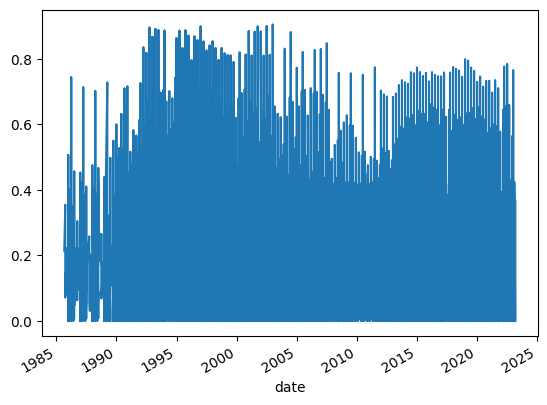

In [255]:
balance_sheet_norm.inventory.plot()

<AxesSubplot:xlabel='date'>

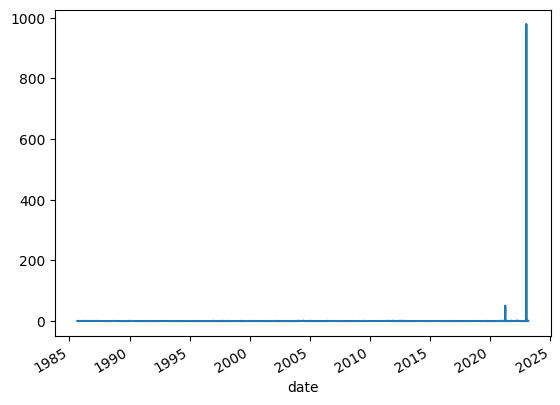

In [256]:
balance_sheet_norm.cashAndCashEquivalents.plot()

<AxesSubplot:xlabel='date'>

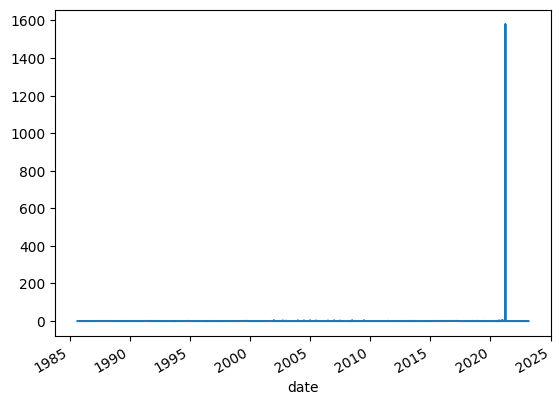

In [257]:
balance_sheet_norm.netReceivables.plot()

<AxesSubplot:>

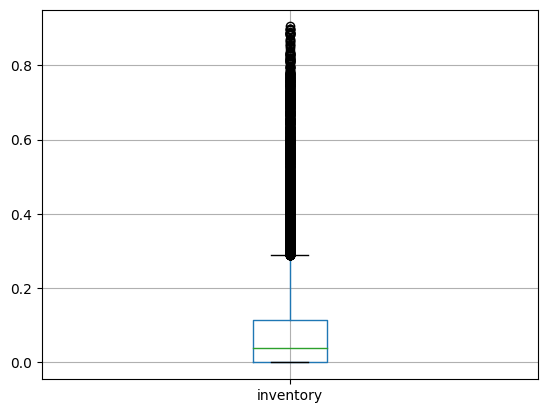

In [258]:
balance_sheet_norm[['inventory']].boxplot()

In [259]:
# Add back the non-numeric columns dropped out from the normalization process to balance_sheet_cleaned

balance_sheet_cleaned[balance_sheet_norm.columns] = balance_sheet_norm

In [260]:
balance_sheet_cleaned

,symbol,reportedCurrency,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,0.114479,0.000000,0.114479,0.133620,0.101749,0.023629,0.373477,0.105046,...,-0.025643,0.489514,0.513692,0.513692,1.0,0.0,1.0,0.000000,0.272095,0.157615
2022-10-31,A,USD,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-10-31,A,USD,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-07-31,A,USD,0.102156,0.000572,0.102728,0.128291,0.096337,0.024609,0.351965,0.100534,...,-0.034529,0.506581,0.485597,0.485597,1.0,0.0,1.0,0.019077,0.277757,0.175601
2022-04-30,A,USD,0.113439,0.002009,0.115447,0.118317,0.089622,0.025060,0.348446,0.096604,...,-0.031851,0.506169,0.489909,0.489909,1.0,0.0,1.0,0.020182,0.277857,0.164419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,WBC.AX,AUD,0.009920,0.000000,0.009920,0.000000,0.000000,0.974500,0.984420,0.015401,...,0.000000,0.063694,0.071650,0.071650,1.0,0.0,1.0,0.000000,0.177352,0.167431
1993-09-30,WBC.AX,AUD,0.015410,0.000000,0.015410,0.000000,0.000000,0.000000,0.000000,0.017697,...,0.000000,0.065851,0.068084,0.068084,1.0,0.0,1.0,0.000000,0.064529,0.049119
1992-09-30,WBC.AX,AUD,0.113525,0.000000,0.113525,0.000000,0.000000,0.000000,0.000000,0.020078,...,0.000000,0.058117,0.060176,0.060176,1.0,0.0,1.0,0.000000,0.061077,-0.052449


In [261]:
# Determine missing balance sheet fields

balance_sheet_cleaned.isnull().sum().sort_values(ascending=False)/len(balance_sheet_cleaned)

othertotalStockholdersEquity               0.002351
symbol                                     0.000000
commonStock                                0.000000
longTermDebt                               0.000000
deferredRevenueNonCurrent                  0.000000
deferredTaxLiabilitiesNonCurrent           0.000000
otherNonCurrentLiabilities                 0.000000
totalNonCurrentLiabilities                 0.000000
otherLiabilities                           0.000000
capitalLeaseObligations                    0.000000
totalLiabilities                           0.000000
preferredStock                             0.000000
retainedEarnings                           0.000000
reportedCurrency                           0.000000
accumulatedOtherComprehensiveIncomeLoss    0.000000
totalStockholdersEquity                    0.000000
totalEquity                                0.000000
totalLiabilitiesAndStockholdersEquity      0.000000
minorityInterest                           0.000000
totalLiabili

<AxesSubplot:>

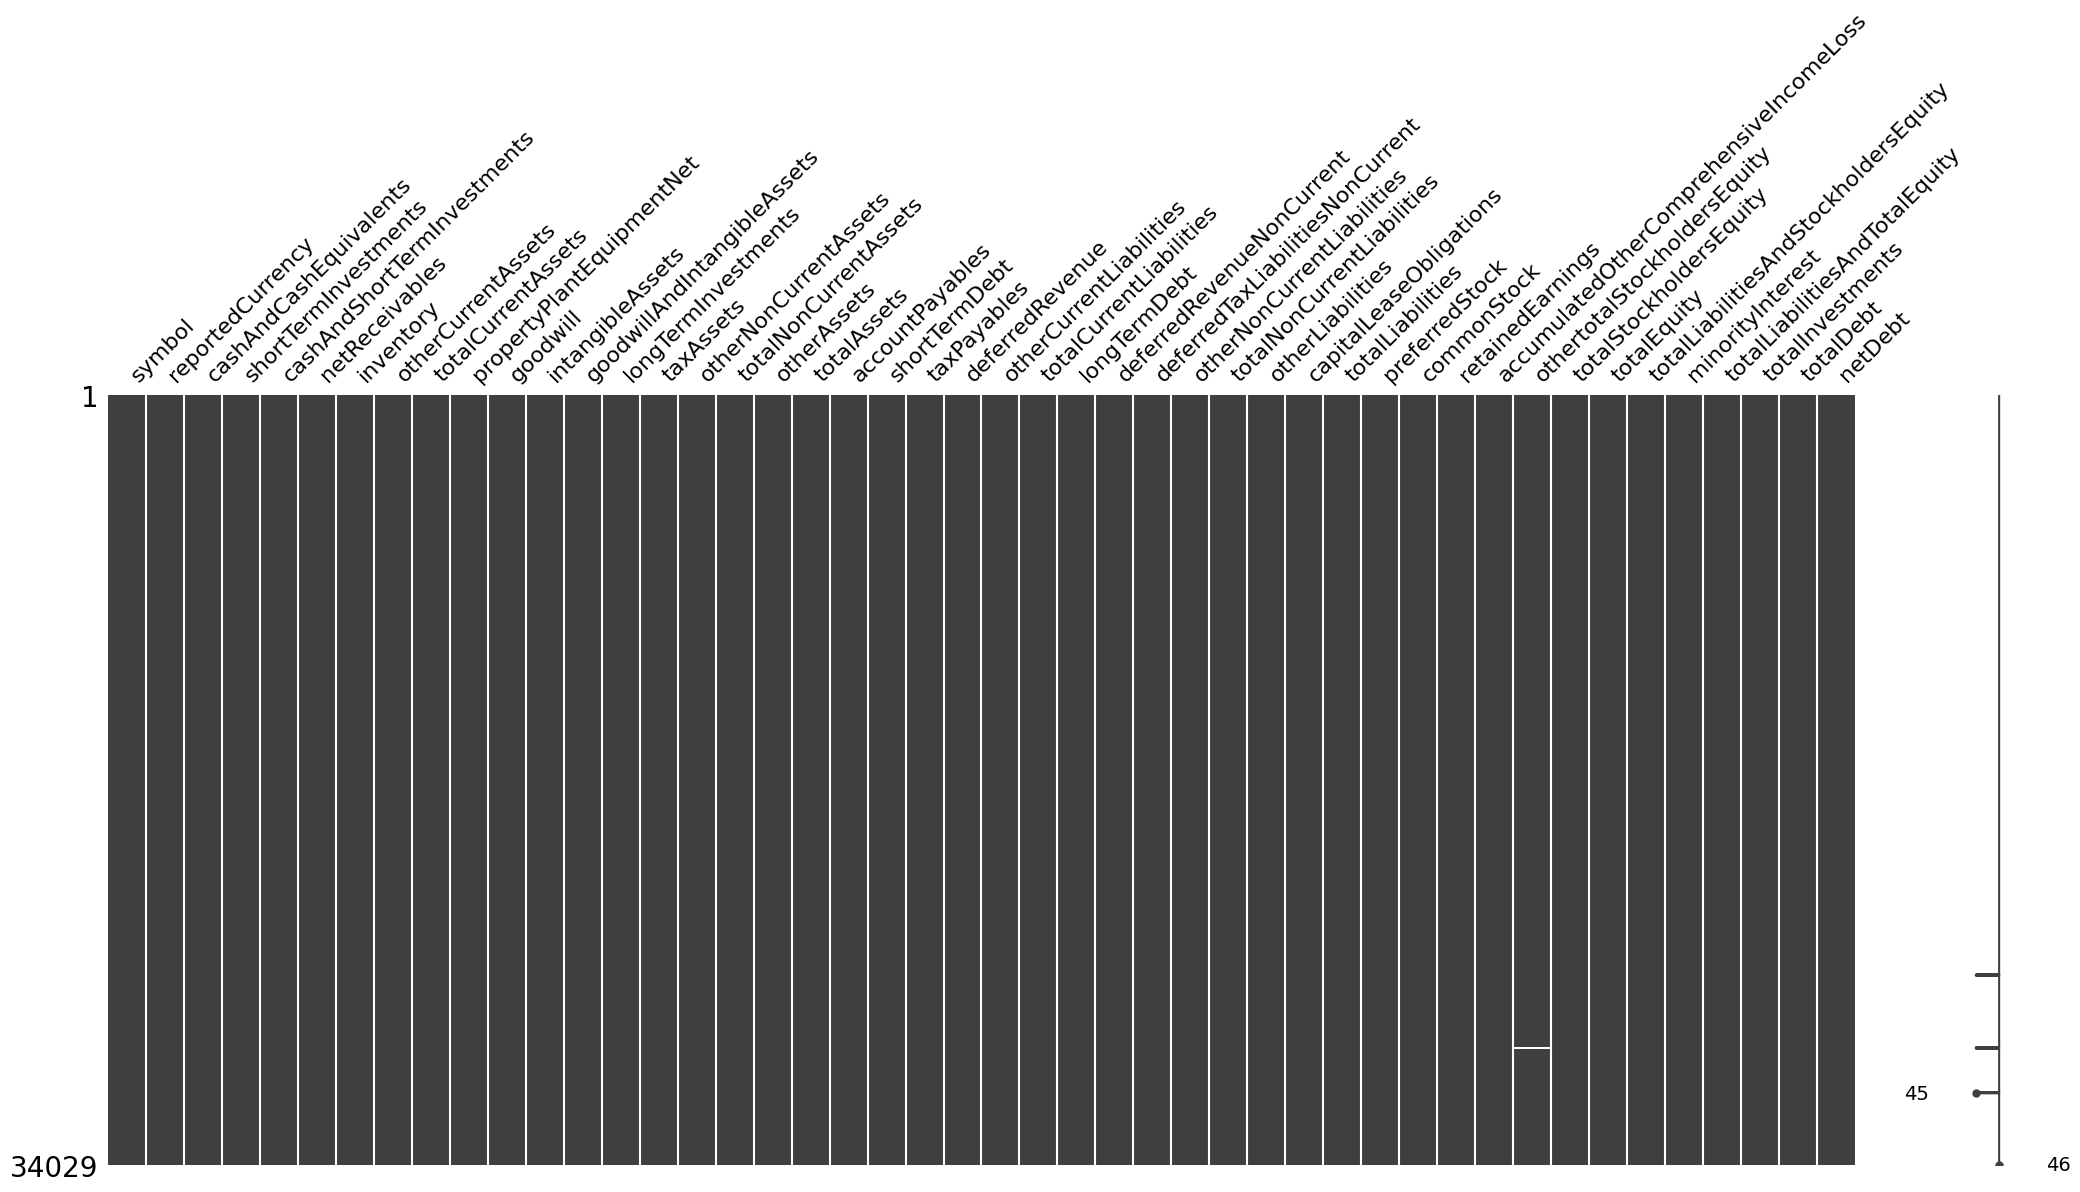

In [294]:
# Heatmap of missing fields

msno.matrix(balance_sheet_cleaned)

In [262]:
# Define missing values
# Use .loc to return values of cells matching condition

BS_missing_data = pd.DataFrame(balance_sheet_cleaned.isna().sum().loc[balance_sheet_cleaned.isna().sum() > 0], columns=['missing_data_count'])
BS_missing_data['missing_data_type'] = balance_sheet_cleaned.dtypes
BS_missing_data['missing_data_percentage'] = BS_missing_data['missing_data_count'] / len(balance_sheet)
BS_missing_data = BS_missing_data.sort_values(by='missing_data_percentage', ascending=False)
BS_missing_data

,missing_data_count,missing_data_type,missing_data_percentage
othertotalStockholdersEquity,80,float64,0.001826


In [263]:
balance_sheet_cleaned['othertotalStockholdersEquity']

date
2023-01-31    0.489514
2022-10-31    0.505602
2022-10-31    0.505602
2022-07-31    0.506581
2022-04-30    0.506169
                ...   
1995-09-30    0.063694
1993-09-30    0.065851
1992-09-30    0.058117
1991-09-30    0.053610
1990-09-30    0.050867
Name: othertotalStockholdersEquity, Length: 34029, dtype: float64

In [264]:
# Show all rows with missing values in 'othertotalStockholdersEquity' column

balance_sheet_cleaned[balance_sheet_cleaned['othertotalStockholdersEquity'].isna()]

,symbol,reportedCurrency,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,0883.HK,CNY,0.033301,0.143460,0.176761,0.027345,0.007825,0.014601,0.226531,0.631977,...,-0.916002,NaN,0.601615,0.601615,1.000000,0.0,1.000000,0.202197,0.188544,0.155243
2019-03-31,0883.HK,CNY,0.044447,0.173370,0.217817,0.033397,0.008333,0.012244,0.271792,0.593526,...,-0.821781,NaN,0.591537,0.591537,1.000000,0.0,1.000000,0.233405,0.196001,0.151554
2018-03-31,0883.HK,CNY,0.021262,0.204843,0.226105,0.034061,0.008621,0.011248,0.280035,0.600103,...,-0.830073,NaN,0.614876,0.614876,1.000000,0.0,1.000000,0.241233,0.205218,0.183957
2017-03-31,0883.HK,CNY,0.020369,0.145391,0.165760,0.034510,0.011915,0.012757,0.224941,0.641374,...,-0.806634,NaN,0.615624,0.615624,1.000000,0.0,1.000000,0.192612,0.214268,0.193899
2016-03-31,0883.HK,CNY,0.021539,0.109356,0.130895,0.036793,0.013657,0.010044,0.191389,0.678719,...,-0.693489,NaN,0.599627,0.599627,1.000000,0.0,1.000000,0.156393,0.235974,0.214435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-01-31,RI.PA,EUR,0.021637,0.000000,0.021637,0.000000,0.287822,0.000000,0.000000,0.116645,...,0.000000,NaN,0.387699,0.387699,0.996465,0.0,0.996465,0.000000,0.000000,-0.021637
2002-09-30,RI.PA,EUR,0.011859,0.000000,0.011859,0.000000,0.279307,0.000000,0.000000,0.108738,...,0.000000,NaN,0.340753,0.340753,0.996816,0.0,0.996816,0.000000,0.000000,-0.011859
2002-06-30,RI.PA,EUR,0.011859,0.000000,0.011859,0.000000,0.279307,0.000000,0.000000,0.108738,...,0.000000,NaN,0.340753,0.340753,0.996816,0.0,0.996816,0.000000,0.000000,-0.011859


<AxesSubplot:xlabel='date'>

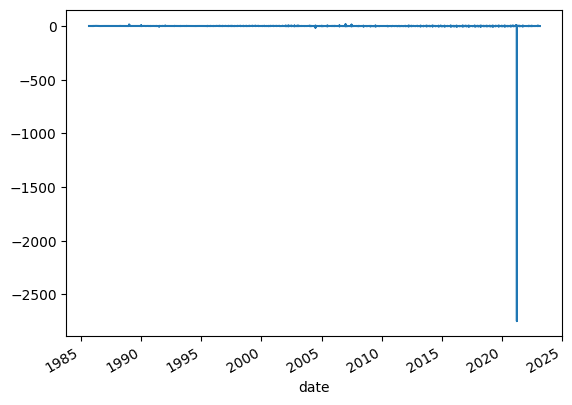

In [282]:
balance_sheet_norm.othertotalStockholdersEquity.plot()

In [12]:
# Process OHE categoricals for MIDAS imputor using cat_conv

categorical = ['symbol','reportedCurrency']
data_cat, cat_cols_list = md.cat_conv(balance_sheet_cleaned[categorical])

balance_sheet_cleaned.drop(categorical, axis = 1, inplace = True)
constructor_list = [balance_sheet_cleaned]
constructor_list.append(data_cat)
data_in = pd.concat(constructor_list, axis=1)

na_loc = data_in.isnull()
data_in[na_loc] = np.nan


In [13]:
# Visalise results

print(data_in.head())

            cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31            1.250000e+09                   0.0   
2022-10-31            1.053000e+09                   0.0   
2022-10-31            1.053000e+09                   0.0   
2022-07-31            1.071000e+09             6000000.0   
2022-04-30            1.186000e+09            21000000.0   

            cashAndShortTermInvestments  netReceivables     inventory  \
date                                                                    
2023-01-31                 1.250000e+09    1.459000e+09  1.111000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-07-31                 1.077000e+09    1.345000e+09  1.010000e+09   
2022-04-30                 1.207000e+09    1.237000e+09  9.370000e+08   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEq

In [15]:
#First, we specify the dimensions, input corruption proportion, and other hyperparameters of the MIDAS neural network. 
#Second, we build a MIDAS model based on the data. The vector of one-hot-encoded column names should be passed to the softmax_columns argument, 
#as MIDAS employs a softmax final-layer activation function for categorical variables. 
#Third, we train the model on the data, setting the number of training epochs as 20 in this example:

imputer = md.Midas(layer_structure = [512,512], vae_layer = False, seed = 89, input_drop = 0.70)
imputer.build_model(data_in, softmax_columns = cat_cols_list)
imputer.train_model(training_epochs = 25)

Size index: [44, 523, 20]

Computation graph constructed

Model initialised

Epoch: 0 , loss: 392309896518631.94
Epoch: 1 , loss: 443958672655807.94
Epoch: 2 , loss: 362033979940517.2
Epoch: 3 , loss: 310451944459054.94
Epoch: 4 , loss: 321259335158097.2
Epoch: 5 , loss: 269021040183895.2
Epoch: 6 , loss: 301276888318934.56
Epoch: 7 , loss: 248490279318802.53
Epoch: 8 , loss: 261437419064222.72
Epoch: 9 , loss: 243826587984750.53
Epoch: 10 , loss: 256599864151193.16
Epoch: 11 , loss: 234909540140834.44
Epoch: 12 , loss: 225333810627638.9
Epoch: 13 , loss: 243622476386068.94
Epoch: 14 , loss: 234454141043528.0
Epoch: 15 , loss: 236377447513541.72
Epoch: 16 , loss: 214693669845386.97
Epoch: 17 , loss: 220254885384581.2
Epoch: 18 , loss: 209886238384513.3
Epoch: 19 , loss: 216671615983905.0
Epoch: 20 , loss: 218544155233042.06
Epoch: 21 , loss: 221117115603943.9
Epoch: 22 , loss: 211433228547365.8
Epoch: 23 , loss: 210717261779452.62
Epoch: 24 , loss: 214756960691085.38
Training complete.

In [16]:
imputations = imputer.generate_samples(m=10).output_list 

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.


TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [265]:
# Train and fit XGBImputer on balance sheet

imputer = XGBImputer(categorical_features_index=[0,1], replace_categorical_values_back=False)
X = imputer.fit_transform(balance_sheet_cleaned)

/Users/veesheenyuen/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgbimputer/xgbimputer.py:147: RuntimeWarning: invalid value encountered in long_scalars
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0000000568


/Users/veesheenyuen/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgbimputer/xgbimputer.py:147: RuntimeWarning: invalid value encountered in long_scalars
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0000000568/0.
XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


/Users/veesheenyuen/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgbimputer/xgbimputer.py:147: RuntimeWarning: invalid value encountered in long_scalars
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


In [267]:
balance_sheet_imputed=pd.DataFrame(X)

In [268]:
balance_sheet_imputed

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,47.0,19.0,0.114479,0.000000,0.114479,0.133620,0.101749,0.023629,0.373477,0.105046,...,-0.025643,0.489514,0.513692,0.513692,1.0,0.0,1.0,0.000000,0.272095,0.157615
1,47.0,19.0,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2,47.0,19.0,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
3,47.0,19.0,0.102156,0.000572,0.102728,0.128291,0.096337,0.024609,0.351965,0.100534,...,-0.034529,0.506581,0.485597,0.485597,1.0,0.0,1.0,0.019077,0.277757,0.175601
4,47.0,19.0,0.113439,0.002009,0.115447,0.118317,0.089622,0.025060,0.348446,0.096604,...,-0.031851,0.506169,0.489909,0.489909,1.0,0.0,1.0,0.020182,0.277857,0.164419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34024,509.0,0.0,0.009920,0.000000,0.009920,0.000000,0.000000,0.974500,0.984420,0.015401,...,0.000000,0.063694,0.071650,0.071650,1.0,0.0,1.0,0.000000,0.177352,0.167431
34025,509.0,0.0,0.015410,0.000000,0.015410,0.000000,0.000000,0.000000,0.000000,0.017697,...,0.000000,0.065851,0.068084,0.068084,1.0,0.0,1.0,0.000000,0.064529,0.049119
34026,509.0,0.0,0.113525,0.000000,0.113525,0.000000,0.000000,0.000000,0.000000,0.020078,...,0.000000,0.058117,0.060176,0.060176,1.0,0.0,1.0,0.000000,0.061077,-0.052449
34027,509.0,0.0,0.091281,0.000000,0.091281,0.000000,0.000000,0.000000,0.000000,0.025971,...,0.000000,0.053610,0.068337,0.068337,1.0,0.0,1.0,0.000000,0.164500,0.073220


In [277]:
# Recover index and column names after numpy array transformation

balance_sheet_imputed = pd.DataFrame(X, index = balance_sheet_cleaned.index, columns = balance_sheet_cleaned.columns)

balance_sheet_imputed

,symbol,reportedCurrency,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,47.0,19.0,0.114479,0.000000,0.114479,0.133620,0.101749,0.023629,0.373477,0.105046,...,-0.025643,0.489514,0.513692,0.513692,1.0,0.0,1.0,0.000000,0.272095,0.157615
2022-10-31,47.0,19.0,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-10-31,47.0,19.0,0.099981,0.000000,0.099981,0.133403,0.098557,0.026776,0.358716,0.104444,...,-0.032947,0.505602,0.503703,0.503703,1.0,0.0,1.0,0.000000,0.262913,0.162932
2022-07-31,47.0,19.0,0.102156,0.000572,0.102728,0.128291,0.096337,0.024609,0.351965,0.100534,...,-0.034529,0.506581,0.485597,0.485597,1.0,0.0,1.0,0.019077,0.277757,0.175601
2022-04-30,47.0,19.0,0.113439,0.002009,0.115447,0.118317,0.089622,0.025060,0.348446,0.096604,...,-0.031851,0.506169,0.489909,0.489909,1.0,0.0,1.0,0.020182,0.277857,0.164419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-09-30,509.0,0.0,0.009920,0.000000,0.009920,0.000000,0.000000,0.974500,0.984420,0.015401,...,0.000000,0.063694,0.071650,0.071650,1.0,0.0,1.0,0.000000,0.177352,0.167431
1993-09-30,509.0,0.0,0.015410,0.000000,0.015410,0.000000,0.000000,0.000000,0.000000,0.017697,...,0.000000,0.065851,0.068084,0.068084,1.0,0.0,1.0,0.000000,0.064529,0.049119
1992-09-30,509.0,0.0,0.113525,0.000000,0.113525,0.000000,0.000000,0.000000,0.000000,0.020078,...,0.000000,0.058117,0.060176,0.060176,1.0,0.0,1.0,0.000000,0.061077,-0.052449


In [276]:
# Check that there are no nans

balance_sheet_imputed[balance_sheet_imputed['othertotalStockholdersEquity'].isna()]

,symbol,reportedCurrency,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,accumulatedOtherComprehensiveIncomeLoss,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt
date,,,,,,,,,,,,,,,,,,,,,


In [287]:
balance_sheet_imputed[['cashAndCashEquivalents']]

,cashAndCashEquivalents
date,
2023-01-31,0.901831
2022-10-31,0.706836
2022-10-31,0.706836
2022-07-31,0.736084
2022-04-30,0.887832
...,...
1995-09-30,-0.504432
1993-09-30,-0.430598
1992-09-30,0.888999


In [291]:
# Create a copy of the imputed BS

balance_sheet_scaled = balance_sheet_imputed.copy()


In [285]:
# Initialise and fit Robust Scaler
# Use RS because data appears to have some very extreme min/max values
# Note [[]] usage otherwise you will get an error with data type

rb_scaler = RobustScaler() 

rb_scaler.fit(balance_sheet_imputed[['cashAndCashEquivalents']]) 


RobustScaler()

In [289]:
balance_sheet_imputed['cashAndCashEquivalents'] = rb_scaler.transform(balance_sheet_imputed[['cashAndCashEquivalents']]) 

In [290]:
balance_sheet_imputed[['cashAndCashEquivalents']]

,cashAndCashEquivalents
date,
2023-01-31,11.491275
2022-10-31,8.868702
2022-10-31,8.868702
2022-07-31,9.262071
2022-04-30,11.303007
...,...
1995-09-30,-7.422188
1993-09-30,-6.429161
1992-09-30,11.318704


## Income Statement

In [17]:
income_statement=pd.read_csv('raw_data/async_IS.csv')

income_statement

,2023-01-31,A,USD,0001090872,2023,Q2,1756000000,788000000,968000000,0.55125284738041,...,0.23348519362186787,58000000,352000000,0.20045558086560364,1.19,1.19.1,296000000,297000000,https://www.sec.gov/Archives/edgar/data/1090872/000109087223000005/0001090872-23-000005-index.htm,https://www.sec.gov/Archives/edgar/data/1090872/000109087223000005/a-20230131.htm
0,2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
1,2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2,2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
3,2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,...,0.231083,68000000.0,329000000.0,0.191502,1.100000,1.100000,2.980000e+08,2.990000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
4,2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,...,0.207218,59000000.0,274000000.0,0.170504,0.920000,0.910000,2.990000e+08,3.010000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52317,1991-12-31,WBC.AX,AUD,NaN,1992,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN
52318,1990-12-31,WBC.AX,AUD,NaN,1991,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.095231,0.095231,1.136867e+09,1.136867e+09,NaN,NaN
52319,1989-12-31,WBC.AX,AUD,NaN,1990,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.166169,0.166169,1.064317e+09,1.064317e+09,NaN,NaN
52320,1988-12-31,WBC.AX,AUD,NaN,1989,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.201700,0.201700,1.064317e+09,1.064317e+09,NaN,NaN


In [18]:
income_statement.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
                           'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses', 
                           'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
                           'operatingExpenses', 'costAndExpenses', 'interestIncome', 'interestExpense', 'depreciationAndAmortization', 
                           'ebitda', 'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
                           'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted',
                           'weightedAverageShsOut', 'weightedAverageShsOutDil', 'link', 'finalLink']

income_statement['date']= pd.to_datetime(income_statement['date'])

income_statement.set_index('date', inplace=True)

income_statement

,symbol,reportedCurrency,cik,calendarYear,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,123000000.0,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,116000000.0,...,0.231083,68000000.0,329000000.0,0.191502,1.100000,1.100000,2.980000e+08,2.990000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,115000000.0,...,0.207218,59000000.0,274000000.0,0.170504,0.920000,0.910000,2.990000e+08,3.010000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-12-31,WBC.AX,AUD,NaN,1992,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN
1990-12-31,WBC.AX,AUD,NaN,1991,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.095231,0.095231,1.136867e+09,1.136867e+09,NaN,NaN
1989-12-31,WBC.AX,AUD,NaN,1990,Q1,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.166169,0.166169,1.064317e+09,1.064317e+09,NaN,NaN


In [99]:
income_statement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52322 entries, 2023-01-31 to 1988-03-31
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   52322 non-null  object 
 1   reportedCurrency                         52322 non-null  object 
 2   cik                                      37743 non-null  float64
 3   calendarYear                             52322 non-null  int64  
 4   period                                   52321 non-null  object 
 5   revenue                                  52322 non-null  float64
 6   costOfRevenue                            52322 non-null  float64
 7   grossProfit                              52322 non-null  float64
 8   grossProfitRatio                         52322 non-null  float64
 9   researchAndDevelopmentExpenses           52322 non-null  float64
 10  generalAndAdministrativeExpen

In [25]:
income_statement[(income_statement['revenue']==0)].count()

symbol                                     1318
reportedCurrency                           1318
cik                                         297
calendarYear                               1318
period                                     1318
revenue                                    1318
costOfRevenue                              1318
grossProfit                                1318
grossProfitRatio                           1318
researchAndDevelopmentExpenses             1318
generalAndAdministrativeExpenses           1318
sellingAndMarketingExpenses                1318
sellingGeneralAndAdministrativeExpenses    1318
otherExpenses                              1318
operatingExpenses                          1318
costAndExpenses                            1318
interestIncome                             1179
interestExpense                            1318
depreciationAndAmortization                1318
ebitda                                     1318
ebitdaratio                             

In [22]:
# Filter all rows with zero revenue

income_statement_zero=income_statement.query("revenue == 0")

income_statement_zero

,symbol,reportedCurrency,cik,calendarYear,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,AMP,USD,820027.0,2021,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.236000e+09,0.0,3.650000,3.580000,1.198000e+08,1.222000e+08,https://www.sec.gov/Archives/edgar/data/820027...,https://www.sec.gov/Archives/edgar/data/820027...
1989-03-31,AXP,USD,4962.0,1989,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.200000,0.200000,1.254477e+09,1.254477e+09,NaN,NaN
1988-03-31,AXP,USD,4962.0,1988,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.200000,0.200000,1.270514e+09,1.270514e+09,NaN,NaN
1987-03-31,AXP,USD,4962.0,1987,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.240000,0.240000,1.292961e+09,1.292961e+09,NaN,NaN
1986-03-31,AXP,USD,4962.0,1986,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.210000,0.210000,1.333880e+09,1.333880e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-12-31,WBC.AX,AUD,NaN,1992,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-3.663055e+08,0.0,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN
1990-12-31,WBC.AX,AUD,NaN,1991,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.095231,0.095231,1.136867e+09,1.136867e+09,NaN,NaN
1989-12-31,WBC.AX,AUD,NaN,1990,Q1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.166169,0.166169,1.064317e+09,1.064317e+09,NaN,NaN


In [30]:
# Remove rows where revenue=0

IS_filtered = income_statement[income_statement['revenue'] > 0]
IS_filtered

,symbol,reportedCurrency,cik,calendarYear,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,123000000.0,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,116000000.0,...,0.231083,68000000.0,329000000.0,0.191502,1.100000,1.100000,2.980000e+08,2.990000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,115000000.0,...,0.207218,59000000.0,274000000.0,0.170504,0.920000,0.910000,2.990000e+08,3.010000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-03-31,WBC.AX,AUD,NaN,2003,Q2,1.817124e+09,0.0,0.000000e+00,0.000000,0.0,...,0.381603,167148940.0,526270920.0,0.289617,0.278254,0.277761,1.827357e+09,1.827357e+09,NaN,NaN
2002-03-31,WBC.AX,AUD,NaN,2002,Q2,1.764159e+09,0.0,0.000000e+00,0.000000,0.0,...,0.395324,187477000.0,509937440.0,0.289054,0.272610,0.271121,1.822322e+09,1.822322e+09,NaN,NaN
2001-03-31,WBC.AX,AUD,NaN,2001,Q2,1.645364e+09,0.0,0.000000e+00,0.000000,0.0,...,0.387218,173196240.0,463918500.0,0.281955,0.248740,0.245750,1.817288e+09,1.817288e+09,NaN,NaN


In [28]:
# Remove rows where revenue=0
# this method has some issues

income_statement_cleaned=income_statement.drop(income_statement[income_statement['revenue'] == 0].index)

income_statement_cleaned

,symbol,reportedCurrency,cik,calendarYear,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023,Q1,1.756000e+09,788000000.0,9.680000e+08,0.551253,123000000.0,...,0.233485,58000000.0,352000000.0,0.200456,1.1900,1.190,296000000.0,297000000.0,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022,Q4,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.2400,1.230,296000000.0,298000000.0,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2023,Q1,1.849000e+09,837000000.0,1.012000e+09,0.547323,119000000.0,...,0.246079,87000000.0,368000000.0,0.199027,1.2400,1.230,296000000.0,298000000.0,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-07-31,A,USD,1090872.0,2022,Q3,1.718000e+09,779000000.0,9.390000e+08,0.546566,116000000.0,...,0.231083,68000000.0,329000000.0,0.191502,1.1000,1.100,298000000.0,299000000.0,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-04-30,A,USD,1090872.0,2022,Q2,1.607000e+09,746000000.0,8.610000e+08,0.535781,115000000.0,...,0.207218,59000000.0,274000000.0,0.170504,0.9200,0.910,299000000.0,301000000.0,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,WBRBY,EUR,NaN,2019,Q3,9.195610e+08,578091000.0,3.414700e+08,0.371340,0.0,...,0.106319,15463000.0,82123000.0,0.089307,0.1380,0.138,571065217.0,571065217.0,NaN,NaN
2021-09-30,WKL.AS,EUR,NaN,2021,Q3,1.192750e+09,343500000.0,8.492500e+08,1.404475,116500000.0,...,5.135630,50250000.0,182000000.0,6.553571,0.6975,0.695,260400000.0,261800000.0,NaN,NaN
2020-03-31,WKL.AS,EUR,NaN,2020,Q1,1.150750e+09,339750000.0,8.110000e+08,1.418927,108250000.0,...,4.912487,54000000.0,180250000.0,6.384189,0.6800,0.675,265000000.0,266600000.0,NaN,NaN


## Cashflow statement

In [7]:
cashflow=pd.read_csv('raw_data/async_CF.csv')

cashflow

,2023-01-31,A,USD,0001090872,2023,Q1,352000000,67000000,4000000,44000000,...,-67000000,125000000,-17000000,22000000,197000000,1253000000,1056000000,296000000.1,-76000000.1,220000000
0,2022-10-31,A,USD,1090872.0,2022,Q4,368000000.0,73000000.0,-17000000.0,26000000.0,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,448000000.0,-7.000000e+07,3.780000e+08
1,2022-07-31,A,USD,1090872.0,2022,Q3,329000000.0,80000000.0,6000000.0,28000000.0,...,-62000000.0,992000000.0,-362000000.0,-6000000.0,-115000000.0,1.073000e+09,1.188000e+09,326000000.0,-8.200000e+07,2.440000e+08
2,2022-04-30,A,USD,1090872.0,2022,Q2,274000000.0,82000000.0,-5000000.0,27000000.0,...,-63000000.0,174000000.0,-123000000.0,-12000000.0,72000000.0,1.188000e+09,1.116000e+09,283000000.0,-6.400000e+07,2.190000e+08
3,2022-01-31,A,USD,1090872.0,2022,Q1,283000000.0,82000000.0,24000000.0,44000000.0,...,-63000000.0,204000000.0,-546000000.0,-4000000.0,-374000000.0,1.116000e+09,1.490000e+09,255000000.0,-7.500000e+07,1.800000e+08
4,2021-10-31,A,USD,1090872.0,2021,Q4,442000000.0,84000000.0,-27000000.0,22000000.0,...,-59000000.0,156000000.0,-324000000.0,-3000000.0,55000000.0,1.490000e+09,1.435000e+09,441000000.0,-6.200000e+07,3.790000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44595,1991-01-31,WBC.AX,AUD,NaN,1991,Q1,119176326.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-4.402573e+07,119176326.5,0.000000e+00,1.191763e+08
44596,1990-09-30,WBC.AX,AUD,NaN,1990,Q4,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
44597,1990-06-30,WBC.AX,AUD,NaN,1990,Q3,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
44598,1990-03-31,WBC.AX,AUD,NaN,1990,Q2,171231579.0,48049059.5,0.0,0.0,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08


In [8]:
cashflow.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'netIncome', 'depreciationAndAmortization',
                   'deferredIncomeTax', 'stockBasedCompensation', 'changeInWorkingCapital', 'accountsReceivables', 'inventory', 'accountsPayables', 'otherWorkingCapital',
                   'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 
                    'acquisitionsNet', 'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment',
                    'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities',
                    'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow']

cashflow['date']= pd.to_datetime(cashflow['date'])

cashflow.set_index('date', inplace=True)

cashflow

,symbol,reportedCurrency,cik,calendarYear,period,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,USD,1090872.0,2022,Q4,368000000.0,73000000.0,-17000000.0,26000000.0,-2.000000e+06,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,448000000.0,-7.000000e+07,3.780000e+08
2022-07-31,A,USD,1090872.0,2022,Q3,329000000.0,80000000.0,6000000.0,28000000.0,-1.310000e+08,...,-62000000.0,992000000.0,-362000000.0,-6000000.0,-115000000.0,1.073000e+09,1.188000e+09,326000000.0,-8.200000e+07,2.440000e+08
2022-04-30,A,USD,1090872.0,2022,Q2,274000000.0,82000000.0,-5000000.0,27000000.0,-9.500000e+07,...,-63000000.0,174000000.0,-123000000.0,-12000000.0,72000000.0,1.188000e+09,1.116000e+09,283000000.0,-6.400000e+07,2.190000e+08
2022-01-31,A,USD,1090872.0,2022,Q1,283000000.0,82000000.0,24000000.0,44000000.0,-2.330000e+08,...,-63000000.0,204000000.0,-546000000.0,-4000000.0,-374000000.0,1.116000e+09,1.490000e+09,255000000.0,-7.500000e+07,1.800000e+08
2021-10-31,A,USD,1090872.0,2021,Q4,442000000.0,84000000.0,-27000000.0,22000000.0,1.000000e+07,...,-59000000.0,156000000.0,-324000000.0,-3000000.0,55000000.0,1.490000e+09,1.435000e+09,441000000.0,-6.200000e+07,3.790000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-01-31,WBC.AX,AUD,NaN,1991,Q1,119176326.5,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-4.402573e+07,119176326.5,0.000000e+00,1.191763e+08
1990-09-30,WBC.AX,AUD,NaN,1990,Q4,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08
1990-06-30,WBC.AX,AUD,NaN,1990,Q3,171231579.0,48049059.5,0.0,0.0,1.460558e+08,...,-138148620.0,0.0,0.0,0.0,0.0,0.000000e+00,-7.228566e+07,864519522.0,-1.421174e+08,7.224022e+08


In [100]:
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44600 entries, 2022-10-31 to 1990-01-31
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   symbol                                    44600 non-null  object 
 1   reportedCurrency                          44600 non-null  object 
 2   cik                                       33066 non-null  float64
 3   calendarYear                              44600 non-null  int64  
 4   period                                    44600 non-null  object 
 5   netIncome                                 44600 non-null  float64
 6   depreciationAndAmortization               44600 non-null  float64
 7   deferredIncomeTax                         44600 non-null  float64
 8   stockBasedCompensation                    44600 non-null  float64
 9   changeInWorkingCapital                    44600 non-null  float64
 10  accountsReceivabl

In [ ]:
# Filter all rows with totalAssets equals zero

income_statement_zero=income_statement.query("totalAssets == 0")

balance_sheet_zero

## Ratios

In [44]:
ratios=pd.read_csv('raw_data/async_ratios.csv')

ratios

,2023-01-31,A,2.106404958677686,1.3992768595041323,0.6456611570247934,303.2659453302961,126.89086294416244,201.66876727218067,61.6751269035533,139.99364036862738,...,25.635353075170844,31.971363636363638,204.61672727272727,152.08,152.08.1,-7.928898181818175,25.635353075170844.1,0.0014883702745354505,93.1009561752988,8.025615974326977.2
0,2022-10-31,A,2.030091,1.320795,0.565825,277.352623,111.612903,180.001221,62.365591,117.635630,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
1,2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2,2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
3,2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
4,2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,...,28.668181,26.916957,125.565119,107.911973,107.911973,0.396911,28.668181,0.001240,88.307740,8.830800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54313,1990-06-30,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
54314,1990-03-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
54315,1990-01-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,7.934432,6.630100,6.630100,0.000000,0.000000,0.024102,0.000000,0.000000
54316,1988-12-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [45]:
ratios.columns =['date','symbol','currentRatio','quickRatio','cashRatio','daysOfSalesOutstanding',
              'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding','cashConversionCycle',
              'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 
             'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 
             'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 
             'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 
             'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 
             'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 
             'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 
             'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 
             'dividendPayoutRatio', 'priceBookValueRatio', 'priceToBookRatio', 'priceToSalesRatio', 
             'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', 'priceCashFlowRatio', 
             'priceEarningsToGrowthRatio', 'priceSalesRatio', 'dividendYield', 'enterpriseValueMultiple', 
             'priceFairValue']

ratios['date']= pd.to_datetime(ratios['date'])

ratios.set_index('date', inplace=True)


In [46]:
ratios

,symbol,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,2.030091,1.320795,0.565825,277.352623,111.612903,180.001221,62.365591,117.635630,0.547323,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,1.940063,1.273396,0.563091,285.753783,116.688062,187.147899,64.467266,122.680633,0.546566,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,2.009377,1.348042,0.654164,280.961419,113.042895,182.321054,60.683646,121.637407,0.535781,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
2022-01-31,A,2.193182,1.491793,0.702652,262.738949,103.547120,168.332067,55.955497,112.376569,0.543608,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
2021-10-31,A,2.224239,1.608314,0.868852,257.698795,98.289474,161.831642,52.815789,109.015853,0.542169,...,28.668181,26.916957,125.565119,107.911973,107.911973,0.396911,28.668181,0.001240,88.307740,8.830800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-06-30,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1990-03-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1990-01-31,WBC.AX,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,...,0.000000,0.000000,7.934432,6.630100,6.630100,0.000000,0.000000,0.024102,0.000000,0.000000


In [ ]:
# Determining missing data

.isnull().sum().sort_values(ascending=False)/len(data)

#  Kaggle CDS Data

In [7]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

CDS=pd.read_csv('raw_data/cds.csv')

In [8]:
CDS['Date']= pd.to_datetime(CDS['Date'])

CDS.set_index('Date', inplace=True)

CDS

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.8500,25.0500,39.0550,73.7150,86.3000,111.3050,125.9050,144.3000,158.6000,168.1950
2015-01-02,A,Agilent Technologies Inc,14.8550,25.1500,39.1600,73.6000,86.4000,111.5100,126.1000,144.3750,158.7750,168.3750
2015-01-05,A,Agilent Technologies Inc,13.4550,24.9600,39.3100,70.2000,88.2600,111.9700,125.0600,143.1650,157.3850,166.8250
2015-01-06,A,Agilent Technologies Inc,15.5350,24.8800,39.3000,72.6800,91.1000,116.6100,130.8900,150.3650,165.6550,175.8850
2015-01-07,A,Agilent Technologies Inc,15.2150,25.5000,40.2700,73.8800,92.5000,117.7800,131.9400,151.1450,166.2150,176.2950
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,ZIGGO,Ziggo,43.1264,87.0118,129.5117,172.7865,214.8831,266.7008,302.0419,327.0323,345.8258,360.3988
2021-09-07,ZIGGO,Ziggo,43.1224,86.7150,132.9410,176.4412,222.3668,277.1234,313.9639,339.7347,358.9416,373.7222
2021-09-08,ZIGGO,Ziggo,42.3178,86.5418,131.5519,178.4565,223.4681,277.5741,314.0263,339.5492,358.5867,373.2473


In [9]:
CDS.isnull().sum() 

Ticker     0
Company    0
PX1        0
PX2        0
PX3        0
PX4        0
PX5        0
PX6        0
PX7        0
PX8        0
PX9        0
PX10       0
dtype: int64

## SAIT Imputation

In [12]:
saits = SAITS(n_steps=48, n_features=33, n_layers=2, d_model=256, d_inner=128, n_head=4, d_k=64, d_v=64, dropout=0.1, epochs=10)

No given device, using default device: cpu
Model initialized successfully. Number of the trainable parameters: 1371446


In [44]:
saits.fit(preimpute_CF)

AssertionError: input should have 3 dimensions [n_samples, seq_len, n_features],but got shape=torch.Size([44600, 31])

In [13]:
from pypots.data import load_specific_dataset, mcar, masked_fill

data = load_specific_dataset('physionet_2012')

Loading the dataset physionet_2012 with TSDB (https://github.com/WenjieDu/Time_Series_Database)...
Starting preprocessing physionet_2012...
Dataset physionet_2012 has already been downloaded. Processing directly...
Dataset physionet_2012 has already been cached. Loading from cache directly...
Loaded successfully!


In [14]:
data['y']

,In-hospital_death
RecordID,
132592,0
140662,0
140104,0
134685,0
134849,0
...,...
158752,0
157307,0
158034,0


In [15]:
data['X']

,RecordID,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.35,NaN,NaN,480.0,NaN,-1.0,NaN
1,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
2,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN
3,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,37.80,NaN,NaN,60.0,NaN,NaN,NaN
4,132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575419,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,...,NaN,NaN,122.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN
575420,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575421,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,147.0,37.30,NaN,NaN,50.0,NaN,NaN,NaN
575422,163037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,...,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wavelet denoising

In [16]:
from scipy import signal

In [17]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

y = denoise_wavelet(df_ratios['quickRatio'], wavelet='db1', mode='soft', method='VisuShrink', rescale_sigma='True')

pd.DataFrame(y).plot()

NameError: name 'df_ratios' is not defined

In [15]:
y

array([1.56077074, 1.56077074, 1.56077074, 1.56077074, 1.56077074,
       1.56077074, 1.56077074, 1.56077074, 1.43139877, 1.22347215,
       1.30451264, 1.30451264, 1.78536851, 2.43249487, 2.30056249,
       2.30056249, 2.71863015, 2.71863015, 2.71863015, 2.71863015,
       2.71863015, 2.71863015, 2.70093592, 2.73632439, 2.66858293,
       2.66858293, 2.66858293, 2.66858293, 2.82760811, 2.82760811,
       2.80541122, 2.61408205, 2.1882202 , 2.1882202 , 2.1882202 ,
       2.1882202 , 2.0190213 , 2.0190213 , 2.0190213 , 2.0190213 ,
       1.61003886, 2.45685163, 2.26276255, 2.26276255, 2.38031213,
       2.38031213, 2.38863092, 1.44316041, 1.31590959, 1.31590959,
       1.31162709, 2.43992805, 1.65615914, 1.65615914, 1.65615914,
       1.65615914, 1.14541934, 1.14541934, 1.08138958, 1.37052575,
       1.73834071, 1.73834071, 1.79707121, 1.79707121, 1.857428  ,
       1.857428  , 1.95484185, 1.76001415, 1.857428  , 1.857428  ,
       1.857428  , 1.857428  , 1.52752891, 1.52752891, 1.52752

In [25]:
# Check output

os.chdir("/Users/veesheenyuen/Desktop/")

list=pd.read_csv('DataScience/Project/async_closing_prices.csv')

list


,A,2023-04-28,135.71
0,A,2023-04-27,133.250000
1,A,2023-04-26,133.120000
2,A,2023-04-25,130.370000
3,A,2023-04-24,138.480000
4,A,2023-04-21,138.500000
...,...,...,...
2771761,RELIANCE.NS,1996-01-05,15.658285
2771762,RELIANCE.NS,1996-01-04,15.766594
2771763,RELIANCE.NS,1996-01-03,15.913584
2771764,RELIANCE.NS,1996-01-02,15.793671


# Merge dataframes based on date index and corresponding symbol

In [35]:
df = balance_sheet.merge(ratios, on=['date', 'symbol'])


In [36]:
df

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
2022-01-31,A,USD,1090872.0,2022-03-03 17:02:17,2022,Q1,1.113000e+09,45000000.0,1.158000e+09,1.205000e+09,...,25.050968,37.045336,232.974000,164.452235,164.452235,-1.040119,25.050968,0.001502,103.204550,8.136461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-30,WBC.AX,AUD,NaN,1994-09-29 20:00:00,1994,Q4,1.077685e+09,0.0,1.077685e+09,0.000000e+00,...,0.000000,11.214489,10.911149,10.425565,10.425565,-0.126076,0.000000,0.008962,69.949640,1.090883
1993-09-30,WBC.AX,AUD,NaN,1993-09-29 20:00:00,1993,Q4,1.618374e+09,0.0,1.618374e+09,0.000000e+00,...,0.000000,141.565103,23.041102,20.913417,20.913417,0.966107,0.000000,0.009133,1081.217056,0.793319
1992-09-30,WBC.AX,AUD,NaN,1992-09-29 20:00:00,1992,Q4,1.253911e+10,0.0,1.253911e+10,0.000000e+00,...,0.000000,-2.075983,6.380719,6.077426,6.077426,0.030294,0.000000,0.021212,4.953820,0.545912


In [49]:
merged_df = balance_sheet.merge(ratios, on=['date', 'symbol'], how='outer')

In [50]:
merged_df.drop_duplicates()

,symbol,reportedCurrency,cik,acceptedDate,calendarYear,period,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,22.147972,27.820380,108.337566,91.409821,91.409821,2.185887,22.147972,0.001514,77.436661,7.719434
2022-07-31,A,USD,1090872.0,2022-08-31 18:53:26,2022.0,Q3,1.071000e+09,6000000.0,1.077000e+09,1.345000e+09,...,23.144435,30.214392,162.959590,121.969755,121.969755,1.544291,23.144435,0.001559,83.877298,7.810281
2022-04-30,A,USD,1090872.0,2022-05-27 19:33:57,2022.0,Q2,1.186000e+09,21000000.0,1.207000e+09,1.237000e+09,...,22.191493,32.538075,162.838950,126.013180,126.013180,-15.292895,22.191493,0.001767,85.735619,6.962462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-06-30,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
1991-01-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,31.585523,31.585523,31.585523,0.000000,0.000000,0.000000,0.000000,0.000000
1990-06-30,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [51]:
merged_df2 = merged_df.merge(income_statement, on=['date', 'symbol'], how='outer')

In [52]:
merged_df2.drop_duplicates()

,symbol,reportedCurrency_x,cik_x,acceptedDate,calendarYear_x,period_x,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,0.233485,58000000.0,352000000.0,0.200456,1.190000,1.190000,2.960000e+08,2.970000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,0.246079,87000000.0,368000000.0,0.199027,1.240000,1.230000,2.960000e+08,2.980000e+08,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,176732262.0,0.000000,0.909215,0.909215,1.801099e+09,1.801099e+09,NaN,NaN
1992-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,9735636.0,0.000000,0.002887,0.002887,1.366274e+09,1.366274e+09,NaN,NaN
1991-12-31,WBC.AX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,-366305480.0,0.000000,-0.206409,-0.206409,1.234180e+09,1.234180e+09,NaN,NaN


In [55]:
final_df = merged_df2.merge(cashflow, on=['date', 'symbol'], how='outer')

In [56]:
final_df.drop_duplicates()

,symbol,reportedCurrency_x,cik_x,acceptedDate,calendarYear_x,period_x,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,A,USD,1090872.0,2023-03-02 18:52:33,2023.0,Q1,1.250000e+09,0.0,1.250000e+09,1.459000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2022.0,Q4,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
2022-10-31,A,USD,1090872.0,2022-12-20 18:42:30,2023.0,Q1,1.053000e+09,0.0,1.053000e+09,1.405000e+09,...,-62000000.0,-144000000.0,-341000000.0,-14000000.0,-17000000.0,1.056000e+09,1.073000e+09,4.480000e+08,-7.000000e+07,378000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-471000000.0,-138000000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.121750e+09,-5.247500e+08,597000000.0
2001-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-493250000.0,92250000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.118750e+09,-3.442500e+08,774500000.0
2000-03-31,0019.HK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-444250000.0,-519750000.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.185250e+09,-5.235000e+08,661750000.0


# KMV Distance to Default Calculator

In [17]:
# Calculate expected return after 1 year

# Import stock portfolio from excel
df = pd.read_excel("Stock_Portfolio.xlsx")

# Calculate beta for each individual stock
for i in range(len(df)):
    x = df.loc[i, "Stock"]
    ticker = yf.Ticker(x)
    stock_beta = ticker.info["beta"]
    df.at[i, "Beta"]= round(stock_beta,2)
    
    
# find the risk free rate (10 year treasury bill)
treasury_yield10 = yf.Ticker("^TNX") 
risk_free_rate_prem = round(treasury_yield10.info['regularMarketPrice']/100,2)
risk_free_rate_prem

# assume 10 percent return on the return of market ( average return of the S&P 500)
sp500_teturn = 0.10

# Caclulate the portfolio beta
portfolio_beta = round(sum(df["Beta"]* df["stock_weight"]/100),2)
portfolio_beta

# Calculate the expected return of the portfolio
portfolio_exp_return = round(risk_free_rate_prem + portfolio_beta *(sp500_teturn - risk_free_rate_prem),2)

#calulate the expected return for each individual stock using CAPM forumla
df["exp_return"]= round(risk_free_rate_prem + df["Beta"]*(sp500_teturn - risk_free_rate_prem),2)

FileNotFoundError: [Errno 2] No such file or directory: 'Stock_Portfolio.xlsx'

In [10]:
import math
from scipy.stats import norm

def kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1):
    """
    KMV Model - https://www.math.ust.hk/~maykwok/Web_ppt/KMV/KMV.pdf
    :param enterprise_value: Enterprise Value of the Firm (can market capitalisation)
    :param short_term_debt: Firm's short term debt
    :param long_term_debt: Firm's long term debt
    :param mu: Expected Return after 1 year
    :param sigma: Expected Annualized Volatility
    :param period: period in years
    :return: EDF (Expected Default Frequency or Probability of Default)
    """

    # Calculate default point
    default_point = short_term_debt + (0.5 * long_term_debt)

    # Numerator
    numer = math.log(enterprise_value / default_point) + (mu - math.pow(sigma, 2) / 2) * period

    # Denominator
    denom = sigma * period

    # Distance to Default
    distance_to_default = numer / denom
    edf = norm.cdf(-distance_to_default)

    return edf

In [11]:
enterprise_value=7.9
short_term_debt=5.0
long_term_debt=5.0
mu=0.1
sigma=0.1

kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1)

0.07083541388671619

# XGBoost Imputer

In [20]:
data = pd.DataFrame({
    'F1': [1, 2, 3, 4],
    'F2': [1, 2, 3, np.nan],
    'F3': [3, 2, 3, 4]
})

imputer = XGBImputer(with_cv=True)
imputer.fit(
    data=data,
    missing_values_variable='F2',
    features=['F1', 'F2'],
    params={'learning_rate':0.3},
    n_jobs=4, # Parallelizing Cross-validation
    n_iter=10 # Random choices among parameters grid
)
imputer.transform(data, 'F1')

TypeError: XGBImputer.fit() got an unexpected keyword argument 'data'